In [ ]:
from shapely import geometry, affinity
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import os
import pandas as pd

def poly2ve(Poly):
    '''Function to convert polygon or multipolygon types in shapely to vertex and edge matrices'''
    
    def edgelist(startid, length, flip=False):
        # helper function to create edge list
        p1 = np.arange(startid, startid+length)
        p2 = p1 + 1
        p2[-1] = startid
        if not flip:
            return np.stack((p1, p2), axis=-1)
        else:
            return np.flipud(np.stack((p2, p1), axis=-1))
    
    def singlePolygon(P):
        # helper function for processing a single polygon instance
        assert(isinstance(P, geometry.polygon.Polygon))
        v = []
        e = []
        ecount = 0
        # exterior
        v_ex = np.array(P.exterior)[:-1]
        e_ex = edgelist(0, v_ex.shape[0])
        v.append(v_ex)
        e.append(e_ex)
        ecount += v_ex.shape[0]
        # interiors
        for int_ in P.interiors:
            v_in = np.array(int_)
            e_in = edgelist(ecount, v_in.shape[0], flip=False)
            v.append(v_in)
            e.append(e_in)
            ecount += v_in.shape[0]
        v = np.concatenate(v, axis=0)
        e = np.concatenate(e, axis=0)
        if not P.exterior.is_ccw:
            e = np.concatenate([e[:, 1:2], e[:, 0:1]], axis=-1) # flip e
        return v, e
         
    if isinstance(Poly, geometry.polygon.Polygon):
        V, E = singlePolygon(Poly)
    elif isinstance(Poly, geometry.multipolygon.MultiPolygon):
        V = []
        E = []
        ecount = 0
        for P in Poly.geoms:
            v, e = singlePolygon(P)
            V.append(v)
            E.append(e+ecount)
            ecount += v.shape[0]
        V = np.concatenate(V, axis=0)
        E = np.concatenate(E, axis=0)
    return V, E

def mnist2poly(image, hd_dim=64, wkt=False):
    image = np.flipud(image)
    # upsample in freq domain
    image_F = np.fft.fftshift(np.fft.rfft2(image), axes=(0))
    pad_w, pad_h = int((hd_dim-image_F.shape[0])/2), int(hd_dim/2+1-image_F.shape[1])
    image_F = np.pad(image_F, ((pad_w, pad_w), (0, pad_h)), 'constant')
    image_F = np.fft.ifftshift(image_F, axes=(0))
    image = np.fft.irfft2(image_F)
    cs = plt.contour(image, [(image.max()+image.min())/2])
    plt.close()
    polys = []
    
    for col in cs.collections:
        # Loop through all polygons that have the same intensity level
        for contour_path in col.get_paths(): 
            # Create the polygon for this intensity level
            # The first polygon in the path is the main one, the following ones are "holes"
            for ncp,cp in enumerate(contour_path.to_polygons()):
                new_shape = geometry.Polygon(cp)
                if ncp == 0:
                    poly = new_shape
                else:
                    # Remove the holes if there are any
                    poly = poly.difference(new_shape)
                if not poly.is_valid:
                    poly = poly.buffer(0)
                polys.append(poly)
    P = polys[-1]
    # if len(polys) > 1:
    #     for i in range(1, len(polys)):
    #         P = P.difference(polys[i]).union(polys[i].difference(P))
    P = affinity.scale(P, 1/hd_dim, 1/hd_dim, 1/hd_dim, (0, 0, 0))
    if wkt:
        return P.wkt
    else:
        return P

def process_mnist2poly(images, labels, outfile, hd_dim=64):
    """
    Process images in mnist dataset given list of images
    Inputs:
    input_list: list containing images
    hd_dim: expansion dimension for extracting contours
    """
    P_list = [None] * len(images)
    for i, im in enumerate(images):
        P_list[i] = mnist2poly(im, hd_dim, True)

    df = pd.DataFrame({'wkt': P_list, 'label': labels})

    df.to_csv(outfile, index=False)
    

def load_mnist_data():
    
    # import torchvision
    # # Download and load the training set
    # trainset = torchvision.datasets.MNIST(root='./dataset', train=True, download=True)
    # # Download and load the test set
    # testset = torchvision.datasets.MNIST(root='./dataset', train=False, download=True)
    # return  trainset.data.numpy(), trainset.targets, testset.data.numpy(), testset.targets

    images_train, labels_train = np.load("dataset/train_images.npy"), np.load("dataset/train_labels.npy")
    images_test, labels_test = np.load("dataset/test_images.npy"), np.load("dataset/test_labels.npy")

    return images_train[:10000], labels_train[:10000], images_test[:2000], labels_test[:2000]

def main():
    images_train, labels_train, images_test, labels_test = load_mnist_data()
    output_root = "dataset/polyMNIST"
    if not os.path.exists(output_root):
        os.makedirs(output_root)
    # train_file = os.path.join(output_root, "mnist_polygon_train_10k.csv")
    test_file = os.path.join(output_root, "mnist_polygon_test_2k.csv")
    print("Processing training files...")
    # process_mnist2poly(images_train, labels_train, outfile=train_file)
    print("Processing test files...")
    process_mnist2poly(images_test, labels_test, outfile=test_file)

if __name__ == '__main__':
    main()

In [7]:
# images_train, labels_train, images_test, labels_test = load_mnist_data()

In [12]:
import pandas as pd
from shapely import wkt

train_data = pd.read_csv("../dataset/mnist_polygon_test_2k.csv")

In [13]:
wkts = train_data['wkt'][:50]
labels = train_data['label']

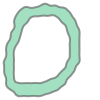

In [14]:
i = 10
wkt.loads(wkts[i])

In [16]:
from deep_geometry import vectorizer as gv
from deep_geometry import GeomScaler

geom_vectors = []
for wkt_str in wkts:
    # print(gv.num_points_from_wkt(wkt_str))
    geom_vectors.append(gv.vectorize_wkt(wkt_str, max_points=64, fixed_size=True, simplify=True))

In [17]:
labels[i]

0

In [160]:
import gzip
import numpy as np

images_test, labels_test = np.load("dataset/test_images.npy"), np.load("dataset/test_labels.npy")

/home/dingkang/envs/nlp_a4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


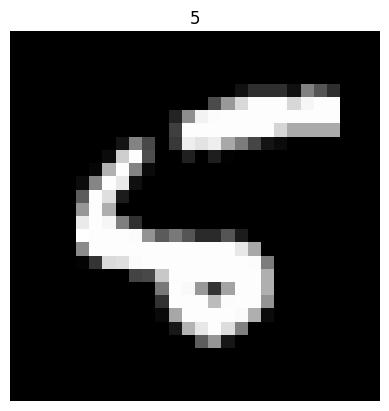

In [1]:
def get_mnist():
    import torchvision
    # Download and load the training set
    trainset = torchvision.datasets.MNIST(root='./dataset', train=True, download=True)
    # Download and load the test set
    testset = torchvision.datasets.MNIST(root='./dataset', train=False, download=True)
    return  trainset.data.numpy(), trainset.targets, testset.data.numpy(), testset.targets

_, _, images_test, labels_test = get_mnist()

import matplotlib.pyplot as plt

i = 8

# Display the image
plt.imshow(images_test[i], cmap='gray')  # Use cmap='gray' for grayscale images
plt.axis('off')  # Turn off axis labels
plt.title(f"{labels_test[i]}")
plt.show()